In [1]:
from pprint import pprint
import pandas as pd
import numpy as np

import seaborn as sns
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tf.enable_v2_behavior()
tfd = tfp.distributions

import warnings
warnings.filterwarnings("ignore")

,F,G,S
2012-01-04 00:00:00,-0.014730,0.005067,0.001569
2012-01-05 00:00:00,0.006770,0.006828,0.002662
2012-01-06 00:00:00,-0.014570,-0.003676,-0.002577
2012-01-09 00:00:00,0.021325,-0.004453,0.002427
2012-01-10 00:00:00,0.022550,0.013674,0.008671


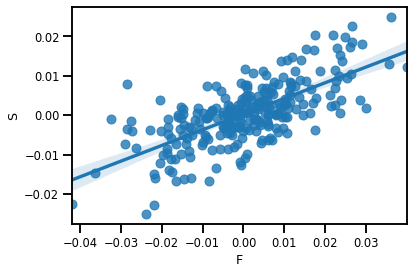

In [107]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()

ret_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v.sort_index(ascending = True, inplace = True)
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    ret_df = pd.concat([ret_df, v["ret"]] , axis = 1)
    
ret_df.columns = data.keys()
display(ret_df.head())
sns.regplot(x="F", y="S", data=ret_df);

In [108]:
x = ret_df["F"].values.reshape(-1,1)
y = ret_df["S"].values

# Build Model

In [109]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [110]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Fit Model

In [111]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss= lambda y, rv_y: -rv_y.log_prob(y))
model.fit(x, y, epochs=1000, verbose=False);

# Run Simulation

In [112]:
x_tst = np.linspace(np.min(x), np.max(x), 50).reshape(-1,1)
yhats = [model(x_tst) for _ in range(500)]

# Plot Model

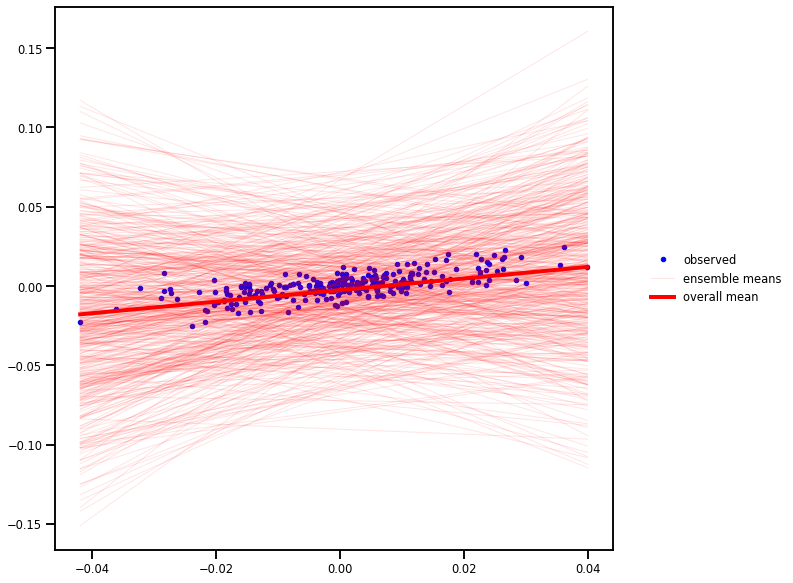

In [115]:

plt.figure(figsize=[10, 10])  
plt.plot(x, y, 'b.', label='observed');

avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 500:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1. , alpha = 0.1)
        # plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
        # plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

# plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)

# Multi variate

In [116]:
x = ret_df[["F","G"]].values.reshape(-1,2)
y = ret_df["S"].values

In [117]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

In [118]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss= lambda y, rv_y: -rv_y.log_prob(y))
model.fit(x, y, epochs=1000, verbose=False);

In [119]:
x_tst = x
yhats = [model(x_tst) for _ in range(500)]

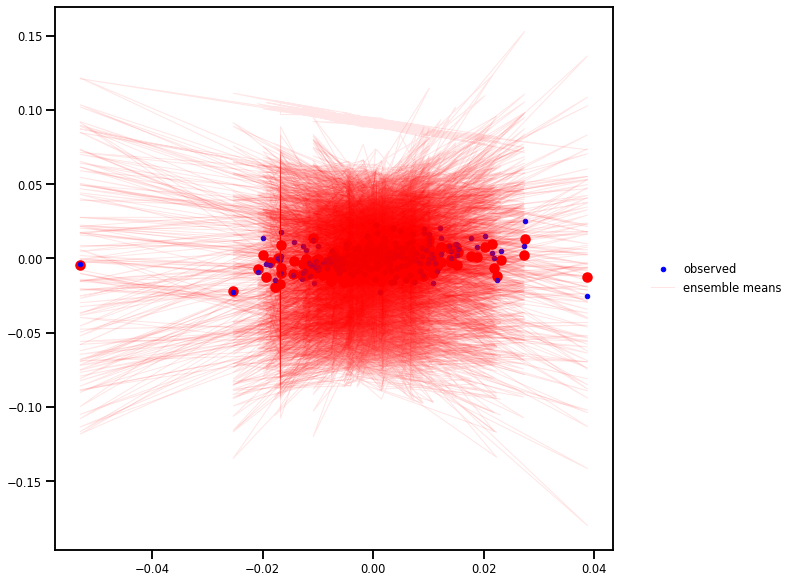

In [149]:
col = 1
plt.figure(figsize=[10, 10])  
plt.plot(x[:,col], y, 'b.', label='observed');

avgm = np.zeros_like(x_tst[..., col])

# Iterate through no. of sample
for i, yhat in enumerate(yhats):
    # for the ith sample, the mean of yhat at each point
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 100:
        plt.plot(x_tst[:,col], m, 'r', label='ensemble means' if i == 0 else None, linewidth=1. , alpha = 0.1)
    # hence we ge the entire line for the ith sample
    # sum of the guess for each point for each of the ith sample
    avgm += m

plt.scatter(x_tst[:,col], avgm/len(yhats) ,c = "r")
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
